# **Deep Learning Models**
   Goal: Capture complex temporal patterns
## Models
 - LSTM
 - GRU
 - Temporal CNN
 - Seq2Seq
 - Transformer (advanced)

## Techniques
 - Sliding windows
 - Multivariate sequences
 - Early stopping

  Output: Best DL model


## DL Foundations & Data Preparation
 - Load feature-engineered dataset
 - Select DL-safe features
 - Normalize numeric features (fit on train only)
 - Encode categoricals (embeddings-ready)
 - Create sliding windows
 - Define sequence tensors
### concepts
 - Multivariate time series
 - Sliding window formulation
 - Sequence-to-one forecasting

### Output
 - X_train_seq, y_train_seq
 - X_valid_seq, y_valid_seq
 - scaler.pkl
 - feature_index.json## Load Feature-Engineered Dataset

In [1]:
# Clone GitHub Repository
!git clone https://github.com/sabin74/Enterprise-Intelligent-Demand-Forecasting-Decision-Optimization-Platform.git

Cloning into 'Enterprise-Intelligent-Demand-Forecasting-Decision-Optimization-Platform'...
remote: Enumerating objects: 260, done.
remote: Counting objects: 100% (44/44), done.
remote: Compressing objects: 100% (44/44), done.
remote: Total 260 (delta 28), reused 0 (delta 0), pack-reused 216 (from 1)
Receiving objects: 100% (260/260), 27.61 MiB | 22.30 MiB/s, done.
Resolving deltas: 100% (140/140), done.
Filtering content: 100% (18/18), 348.57 MiB | 50.72 MiB/s, done.


In [1]:
# Import Libraries
# Imports
import os
import gc
import time
import json
import joblib
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.preprocessing import StandardScaler

In [2]:
# Set random seeds for reproducibility
import tensorflow as tf
np.random.seed(42)
tf.random.set_seed(42)

In [3]:
# Set Project Root
os.chdir('/content/Enterprise-Intelligent-Demand-Forecasting-Decision-Optimization-Platform')
print("Current Directory: ", os.getcwd())

Current Directory:  /content/Enterprise-Intelligent-Demand-Forecasting-Decision-Optimization-Platform


In [4]:
# Load Feature Engineered Data
df = pd.read_parquet("data/features/train_features.parquet")

df["date"] = pd.to_datetime(df["date"])
df = df.sort_values(["store_nbr", "family", "date"]).reset_index(drop=True)

print(df.shape)
df.head()

(3054348, 62)


,id,date,store_nbr,family,sales,onpromotion,city,state,store_type,cluster,...,is_comp_workday,is_pre_holiday,is_post_holiday,family_freq,store_freq,city_freq,state_freq,sales_log,family_te,store_te
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,...,0,0,0,0.030303,0.018519,0.333333,0.351852,0.000000,1.612195,3.148359
1,1782,2013-01-02,1,AUTOMOTIVE,2.0,0,Quito,Pichincha,D,13,...,0,0,1,0.030303,0.018519,0.333333,0.351852,1.098612,1.612195,3.148359
2,3564,2013-01-03,1,AUTOMOTIVE,3.0,0,Quito,Pichincha,D,13,...,0,0,0,0.030303,0.018519,0.333333,0.351852,1.386294,1.612195,3.148359
3,5346,2013-01-04,1,AUTOMOTIVE,3.0,0,Quito,Pichincha,D,13,...,0,0,0,0.030303,0.018519,0.333333,0.351852,1.386294,1.612195,3.148359
4,7128,2013-01-05,1,AUTOMOTIVE,5.0,0,Quito,Pichincha,D,13,...,1,0,0,0.030303,0.018519,0.333333,0.351852,1.791759,1.612195,3.148359


In [5]:
# Train Validatoin Split
SPLIT_DATE = "2017-01-01"

train_df = df[df["date"] < SPLIT_DATE].copy()
valid_df = df[df["date"] >= SPLIT_DATE].copy()

print(train_df.shape, valid_df.shape)


(2642706, 62) (411642, 62)


In [6]:
# Drop NaN values in Lag/Roll Features
# identify Lag/Roll Columns
lag_cols = [col for col in train_df.columns if "lag" in col or "roll" in col]

# Drop NaN
initial_rows = len(train_df)

train_df = train_df.dropna(subset=lag_cols)

print(f"Rows dropped: {initial_rows - len(train_df)}")
print(f"Remaining Rows: {len(train_df)}")
print(f"Loose Percentage: {100 * (initial_rows - len(train_df)) / initial_rows:.2f}")


Rows dropped: 49896
Remaining Rows: 2592810
Loose Percentage: 1.89


In [7]:
# Feature Selection
TARGET = "sales_log"

NUMERIC_FEATURES = [
    "onpromotion",
    "cluster",
    "dcoilwtico",
    "is_holiday",
    "is_workday",
    "earthquake",
    "is_payday",
    "week_of_year",
    "is_weekend",
    "is_month_end",

    "sales_lag_1",
    "sales_lag_7",
    "sales_lag_14",
    "sales_lag_28",

    "promo_lag_1",
    "promo_lag_7",

    "oil_lag_7",
    "oil_lag_14",
    "oil_lag_28",

    "sales_roll_mean_7",
    "sales_roll_mean_14",
    "sales_roll_mean_28",

    "sales_roll_std_7",
    "sales_roll_std_14",
    "sales_roll_std_28",

    "promo_roll_sum_7",
    "promo_roll_sum_14",
    "promo_roll_sum_28",

    "promo_flag",
    "promo_freq_7",
    "promo_freq_14",
    "promo_freq_28",

    "is_national_holiday",
    "is_regional_holiday",
    "is_local_holiday",
    "is_bridge",
    "is_comp_workday",
    "is_pre_holiday",
    "is_post_holiday",

    "family_freq",
    "store_freq",
    "city_freq",
    "state_freq",
]


CATEGORICAL_FEATURES = [
    "store_nbr",
    "family",
    "city",
    "state",
    "store_type",
    "holiday_type",
    "locale",
]

DL_FEATURES = NUMERIC_FEATURES + CATEGORICAL_FEATURES

In [8]:
# Encode Categoricals (Integer IDs for Embeddings)
# Build Category
category_maps = {}

for col in CATEGORICAL_FEATURES:
  category_maps[col] = {
      v: i + 1 for i, v in enumerate(train_df[col].astype(str).unique())
    }


In [9]:
# Apply Encoding
def encode_categories(df, maps):
  df = df.copy()
  for col, mp in maps.items():
    df[col] = df[col].astype(str).map(mp).fillna(0).astype("int32")
  return df

train_df = encode_categories(train_df, category_maps)
valid_df = encode_categories(valid_df, category_maps)


In [10]:
# Normalize Numeric Features
scaler = StandardScaler()

train_df[NUMERIC_FEATURES] = scaler.fit_transform(train_df[NUMERIC_FEATURES])
valid_df[NUMERIC_FEATURES] = scaler.transform(valid_df[NUMERIC_FEATURES])


In [11]:
# Save scaler
joblib.dump(scaler, "models/scaler.pkl")

['models/scaler.pkl']

In [12]:
# Memory Optimization (reduce memory usage)
def reduce_mem(df):
  for c in df.columns:
    if df[c].dtype == "float64":
      df[c] = df[c].astype("float32")
    elif df[c].dtype == "int64":
      df[c] = df[c].astype("int32")
  return df

train_df = reduce_mem(train_df)
valid_df = reduce_mem(valid_df)
gc.collect()


0

## Sliding Window Generator (Reusable Engine)

All DL models will reuse this logic.

### Build window generator:
 - window_size = 28
 - horizon = 1
 - Ensure time continuity per store-family
 - Batch-safe generator


In [13]:
# Sliding Window Function
def sliding_window_generator(
    df,
    window_size,
    horizon,
    feature_cols,
    target_col,
    batch_size=256,
):
    X_batch, y_batch = [], []

    for _, gdf in df.groupby(["store_nbr", "family"]):
        gdf = gdf.sort_values("date")

        X = gdf[feature_cols].values.astype("float32")
        y = gdf[target_col].values.astype("float32")

        if len(gdf) < window_size + horizon:
            continue

        for i in range(len(gdf) - window_size - horizon + 1):
            X_batch.append(X[i:i+window_size])
            y_batch.append(y[i+window_size+horizon-1])

            if len(X_batch) == batch_size:
                yield np.array(X_batch), np.array(y_batch)
                X_batch, y_batch = [], []

    if X_batch:
        yield np.array(X_batch), np.array(y_batch)



In [14]:
## tf.data Dataset Wrapper
WINDOW_SIZE = 28
HORIZON = 1
BATCH_SIZE = 256

def make_dataset(df, shuffle=False):
  ds = tf.data.Dataset.from_generator(
    lambda: sliding_window_generator(
      df, WINDOW_SIZE, HORIZON, DL_FEATURES, TARGET, BATCH_SIZE
    ),
    output_signature=(
      tf.TensorSpec(shape=(None, WINDOW_SIZE, len(DL_FEATURES)), dtype=tf.float32),
      tf.TensorSpec(shape=(None,), dtype=tf.float32),
    ),
  )
  if shuffle:
      ds = ds.shuffle(1024)
  return ds.prefetch(tf.data.AUTOTUNE)

# Train and Validation datasets
train_ds = make_dataset(train_df, shuffle=True)
valid_ds = make_dataset(valid_df)


In [15]:
# Save Feature Map
feature_map = {
  "numeric_features": NUMERIC_FEATURES,
  "categorical_features": CATEGORICAL_FEATURES,
  "dl_features_order": DL_FEATURES,
  "category_maps": category_maps,
  "window_size": WINDOW_SIZE,
}

with open("models/dl_feature_map.json", "w") as f:
  json.dump(feature_map, f, indent=4)


In [16]:
# RMSLE Functoin
def rmsle_log(y_true, y_pred):
  y_true = np.expm1(y_true)
  y_pred = np.expm1(y_pred)
  y_pred = np.maximum(y_pred, 0)
  return np.sqrt(np.mean((np.log1p(y_true) - np.log1p(y_pred))**2))



## Model 1: LSTM (Baseline DL)
 - Handles long dependencies
 - Strong baseline
 - Easy to interpret
### What we do
 - Build LSTM architecture
 - Sequence → Dense output
 - Early stopping


In [ ]:
STEPS_PER_EPOCH = 2000
VAL_STEPS = 500

In [ ]:
# Built LSMT Model - Basseline Architecture
lstm_model = Sequential([
  LSTM(64, input_shape=(WINDOW_SIZE, len(DL_FEATURES))),
  Dropout(0.2),
  Dense(1)
])

lstm_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, clipnorm=1.0),
    loss="mse"
)

lstm_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        29,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,505 (115.25 KB)

 Trainable params: 29,505 (115.25 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Training Setup

callbacks = [
  EarlyStopping(patience=5, restore_best_weights=True),
  ModelCheckpoint("models/lstm_best.keras", save_best_only=True)
]


In [ ]:
# Train_model
history = lstm_model.fit(
  train_ds,
  validation_data=valid_ds,
  epochs=30,
  steps_per_epoch=STEPS_PER_EPOCH,
  validation_steps=VAL_STEPS,
  callbacks=callbacks,
  verbose=1
)


Epoch 1/30
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 167s 80ms/step - loss: 3.3328 - val_loss: 0.7286
Epoch 2/30
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 144s 72ms/step - loss: 1.5586 - val_loss: 0.6505
Epoch 3/30
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 143s 72ms/step - loss: 1.2314 - val_loss: 0.6845
Epoch 4/30
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 202s 101ms/step - loss: 1.1641 - val_loss: 0.7665
Epoch 5/30
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 144s 72ms/step - loss: 1.2638 - val_loss: 0.9012
Epoch 6/30
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 201s 97ms/step - loss: 1.1177 - val_loss: 0.7638
Epoch 7/30
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 199s 99ms/step - loss: 1.0001 - val_loss: 0.5243
Epoch 8/30
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 141s 71ms/step - loss: 1.0396 - val_loss: 0.7607
Epoch 9/30
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 202s 101ms/step - loss: 1.1056 - val_loss: 0.6209
Epoch 10/30
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 133s 66ms/step - loss: 1.0762 - val_loss: 0.7587
Epoch 11/30
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 202s 98ms/step - loss: 0.9848 - val_loss: 0.

In [ ]:
# Predict and Evaluate
X_val, y_val = next(sliding_window_generator(
  valid_df, WINDOW_SIZE, HORIZON, DL_FEATURES, TARGET, batch_size=2048
))

y_pred = lstm_model.predict(X_val).reshape(-1)
print("LSTM RMSLE:", rmsle_log(y_val, y_pred))



64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
LSTM RMSLE: 0.6515475


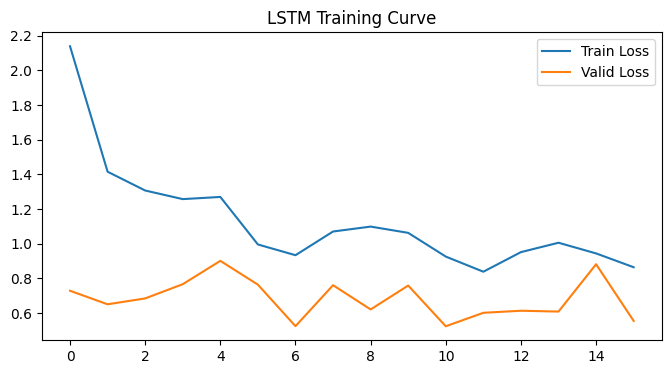

In [ ]:
# Training Curves
plt.figure(figsize=(8, 4))
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Valid Loss")
plt.legend()
plt.title("LSTM Training Curve")
plt.show()


In [ ]:
# Save Model and Training History

lstm_model.save("models/lstm_model.keras")

# Save Training History
with open("models/lstm_history.json", "w") as f:
    json.dump(history.history, f)


## Model 2: GRU (Faster LSTM)
 - Faster than LSTM
 - Often same or better performance

### What we do
 - Replace LSTM with GRU
 - Same window & data
 - Compare speed vs accuracy


In [18]:
# Build GRU Model
num_features = len(DL_FEATURES)

gru_model = Sequential([
    GRU(
        units=64,
        return_sequences=False,
        input_shape=(WINDOW_SIZE, num_features)
    ),
    Dropout(0.2),
    Dense(1)
])


In [19]:
# Compile GRU Modle
gru_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, clipnorm=1.0),
    loss="mse"
)

gru_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 64)             │        22,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,337 (87.25 KB)

 Trainable params: 22,337 (87.25 KB)

 Non-trainable params: 0 (0.00 B)

In [20]:
# Set Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
checkpoint =ModelCheckpoint("models/gru_best.keras", save_best_only=True)

In [ ]:
# Train GRU Model
start_time = time.time()

history_gru = gru_model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=7,
    callbacks=[early_stopping, checkpoint],
    verbose=1
)

gru_training_time = time.time() - start_time
print(f"GRU Training Time: {gru_training_time:.2f} seconds")

Epoch 1/7
9934/9934 ━━━━━━━━━━━━━━━━━━━━ 92s 9ms/step - loss: 2.1058 - val_loss: 0.9050
Epoch 2/7
9934/9934 ━━━━━━━━━━━━━━━━━━━━ 87s 8ms/step - loss: 1.0309 - val_loss: 0.7086
Epoch 3/7
9934/9934 ━━━━━━━━━━━━━━━━━━━━ 88s 8ms/step - loss: 0.8664 - val_loss: 0.6243
Epoch 4/7
9934/9934 ━━━━━━━━━━━━━━━━━━━━ 89s 9ms/step - loss: 0.8396 - val_loss: 0.6584
Epoch 5/7
9934/9934 ━━━━━━━━━━━━━━━━━━━━ 142s 14ms/step - loss: 0.7534 - val_loss: 0.5941
Epoch 6/7
9934/9934 ━━━━━━━━━━━━━━━━━━━━ 88s 9ms/step - loss: 0.7291 - val_loss: 0.6285
Epoch 7/7
9934/9934 ━━━━━━━━━━━━━━━━━━━━ 88s 9ms/step - loss: 0.7015 - val_loss: 0.5566
GRU Training Time: 673.05 seconds


In [ ]:
# Evaluate GRU RMSLE
y_true_all = []
y_pred_all = []

for X_batch, y_batch in valid_ds:
    preds = gru_model.predict(X_batch, verbose=0).reshape(-1)
    y_true_all.append(y_batch.numpy())
    y_pred_all.append(preds)

y_true_all = np.concatenate(y_true_all)
y_pred_all = np.concatenate(y_pred_all)

gru_rmsle = rmsle_log(y_true_all, y_pred_all)
print(f"GRU RMSLE: {gru_rmsle:.4f}")

GRU RMSLE: 0.7459


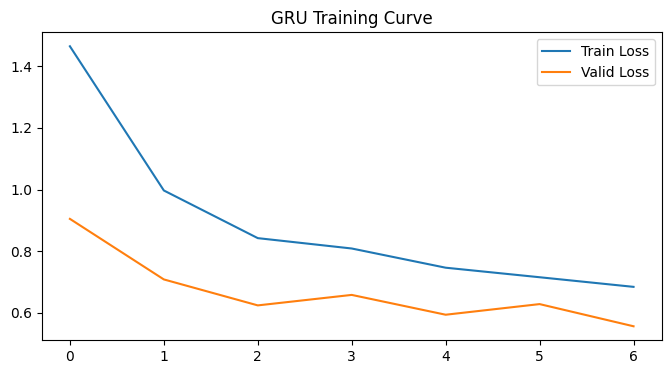

In [ ]:
# GRU Training Curves
plt.figure(figsize=(8, 4))
plt.plot(history_gru.history["loss"], label="Train Loss")
plt.plot(history_gru.history["val_loss"], label="Valid Loss")
plt.legend()
plt.title("GRU Training Curve")
plt.show()

In [ ]:
# Save Model
gru_model.save("models/gru_model.keras")

# Save Training History
with open("models/gru_history.json", "w") as f:
    json.dump(history_gru.history, f)

## Model 3: Temporal CNN (TCN)
 - Captures local temporal patterns
 - Much faster than RNNs
 - Strong industrial baseline

### What we do
 - 1D Convolutions
 - Dilated causal convolutions
 - Residual blocks


In [21]:
# TCN Residual Block
def tcn_block(
    x,
    filters,
    kernel_size,
    dilation_rate,
    dropout=0.1,
):
    residual = x

    x = layers.Conv1D(
        filters,
        kernel_size,
        padding="causal",
        dilation_rate=dilation_rate,
        activation="relu",
    )(x)

    x = layers.LayerNormalization()(x)
    x = layers.Dropout(dropout)(x)

    x = layers.Conv1D(
        filters,
        kernel_size,
        padding="causal",
        dilation_rate=dilation_rate,
        activation="relu",
    )(x)

    x = layers.LayerNormalization()(x)

    # Match channels
    if residual.shape[-1] != filters:
        residual = layers.Conv1D(filters, 1, padding="same")(residual)

    return layers.Add()([residual, x])


In [22]:
# Build TCN Model
def build_tcn_model(
    input_shape,
    filters=32,
    kernel_size=3,
    dilations=[1, 2, 4],
    dropout=0.1,
):
    inputs = layers.Input(shape=input_shape)
    x = inputs

    for d in dilations:
        x = tcn_block(
            x,
            filters=filters,
            kernel_size=kernel_size,
            dilation_rate=d,
            dropout=dropout,
        )

    # Use last timestep only (sequence-to-one)
    x = layers.Lambda(lambda t: t[:, -1, :])(x)

    x = layers.Dense(64, activation="relu")(x)
    outputs = layers.Dense(1)(x)

    model = models.Model(inputs, outputs)
    return model



In [23]:
# Compile Model
tcn_model = build_tcn_model(
    input_shape=(WINDOW_SIZE, len(DL_FEATURES)),
    filters=32,
    kernel_size=3,
    dilations=[1, 2, 4],
    dropout=0.1,
)

tcn_model.compile(
    optimizer=tf.keras.optimizers.Adam(
        learning_rate=1e-3,
        clipnorm=1.0
    ),
    loss="mse",
)

tcn_model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 28, 50)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 28, 32)    │      4,832 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 28, 32)    │         64 │ conv1d[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 28, 32)    │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 28, 32)    │      3,104 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 28, 32)    │      1,632 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 28, 32)    │         64 │ conv1d_1[0][0]    │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 28, 32)    │          0 │ conv1d_2[0][0],   │
│                     │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 28, 32)    │      3,104 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 28, 32)    │         64 │ conv1d_3[0][0]    │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 28, 32)    │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 28, 32)    │      3,104 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 28, 32)    │         64 │ conv1d_4[0][0]    │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 28, 32)    │          0 │ add[0][0],        │
│                     │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 28, 32)    │      3,104 │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 28, 32)    │         64 │ conv1d_5[0][0]    │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 28, 32)    │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 28, 32)    │      3,104 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 28, 32)    │         64 │ conv1d_6[0][0]    │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 28, 32)    │          0 │ add_1[0][0],      │
│                     │                   │            │ layer_normalizat

 Total params: 24,545 (95.88 KB)

 Trainable params: 24,545 (95.88 KB)

 Non-trainable params: 0 (0.00 B)

In [24]:
# Train with Early stoppings
callbacks = [
    EarlyStopping(
        monitor="val_loss",
        patience=3,
        restore_best_weights=True
    ),
    ModelCheckpoint(
        "models/tcn_best.keras",
        save_best_only=True
    ),
]

history_tcn = tcn_model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=10,
    callbacks=callbacks,
    verbose=1,
)



Epoch 1/10
9934/9934 ━━━━━━━━━━━━━━━━━━━━ 99s 8ms/step - loss: 2.4541 - val_loss: 1.0126
Epoch 2/10
9934/9934 ━━━━━━━━━━━━━━━━━━━━ 77s 7ms/step - loss: 1.2715 - val_loss: 0.9951
Epoch 3/10
9934/9934 ━━━━━━━━━━━━━━━━━━━━ 81s 7ms/step - loss: 1.1108 - val_loss: 1.0686
Epoch 4/10
9934/9934 ━━━━━━━━━━━━━━━━━━━━ 75s 7ms/step - loss: 0.9915 - val_loss: 0.8557
Epoch 5/10
9934/9934 ━━━━━━━━━━━━━━━━━━━━ 75s 7ms/step - loss: 0.9390 - val_loss: 1.2303
Epoch 6/10
9934/9934 ━━━━━━━━━━━━━━━━━━━━ 76s 7ms/step - loss: 0.8911 - val_loss: 1.4985
Epoch 7/10
9934/9934 ━━━━━━━━━━━━━━━━━━━━ 74s 7ms/step - loss: 0.9168 - val_loss: 1.0921


In [25]:
# Evaluate Temporac CNN RMSLE
y_true_all = []
y_pred_all = []

for X_batch, y_batch in valid_ds:
    preds = tcn_model.predict(X_batch, verbose=0).reshape(-1)
    y_true_all.append(y_batch.numpy())
    y_pred_all.append(preds)

y_true_all = np.concatenate(y_true_all)
y_pred_all = np.concatenate(y_pred_all)

tcn_rmsle = rmsle_log(y_true_all, y_pred_all)
print(f"TCN RMSLE: {tcn_rmsle:.4f}")

TCN RMSLE: 0.9142


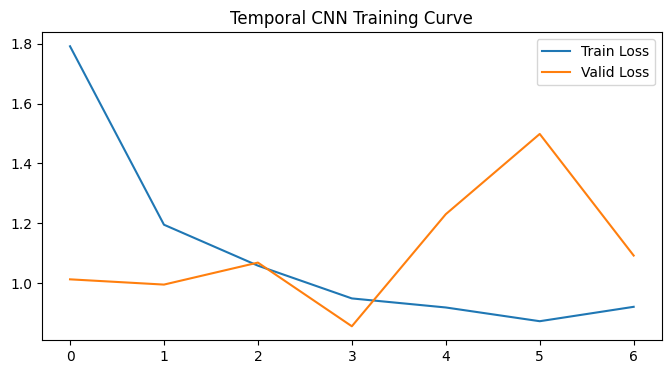

In [27]:
# TCN Training Curves
plt.figure(figsize=(8, 4))
plt.plot(history_tcn.history["loss"], label="Train Loss")
plt.plot(history_tcn.history["val_loss"], label="Valid Loss")
plt.legend()
plt.title("Temporal CNN Training Curve")
plt.show()

In [28]:
# Save Model
tcn_model.save("models/tcn_model.keras")

# Save Model History
with open("models/tcn_history.json", "w") as f:
    json.dump(history_tcn.history, f)


## Model 4: Seq2Seq (Encoder–Decoder)
 - Flexible horizons
 - Industry standard for forecasting

### What we do
 - Encoder–decoder architecture
 - Sequence → sequence
 - Teacher forcing

In [18]:
# Build Encoder Decoder Input
def create_decoder_input(y, horizon):
    start_token = tf.zeros_like(y[:, :1])
    return tf.concat([start_token, y[:, :-1]], axis=1)


In [19]:
# Seq2Seq Model (Encoder - Decoder)
def build_seq2seq_model(
    window_size,
    horizon,
    numeric_dim,
    category_maps,
    embed_dim=8,
    hidden_dim=128,
    dropout=0.2,
):
    # -------- Encoder --------
    enc_num = tf.keras.Input(
        shape=(window_size, numeric_dim),
        name="encoder_numeric",
    )

    enc_cat_inputs = []
    enc_cat_embeds = []

    for col, mapping in category_maps.items():
        inp = tf.keras.Input(shape=(window_size,), name=f"enc_{col}")
        emb = tf.keras.layers.Embedding(
            input_dim=len(mapping) + 1,
            output_dim=embed_dim,
        )(inp)

        enc_cat_inputs.append(inp)
        enc_cat_embeds.append(emb)

    enc_x = tf.keras.layers.Concatenate()([enc_num] + enc_cat_embeds)
    enc_x = tf.keras.layers.LayerNormalization()(enc_x)

    encoder_lstm = tf.keras.layers.LSTM(
        hidden_dim,
        return_state=True,
        dropout=dropout,
    )

    _, state_h, state_c = encoder_lstm(enc_x)

    # -------- Decoder --------
    dec_input = tf.keras.Input(
        shape=(horizon, 1),
        name="decoder_input",
    )

    decoder_lstm = tf.keras.layers.LSTM(
        hidden_dim,
        return_sequences=True,
        dropout=dropout,
    )

    dec_x = decoder_lstm(dec_input, initial_state=[state_h, state_c])
    dec_x = tf.keras.layers.Dense(1)(dec_x)

    seq2seq_model = tf.keras.Model(
        inputs=[enc_num] + enc_cat_inputs + [dec_input],
        outputs=dec_x,
    )

    return seq2seq_model



In [20]:
# Compile Model
def rmsle_tf(y_true, y_pred):
    y_true = tf.exp(y_true)
    y_pred = tf.exp(y_pred)
    return tf.sqrt(
        tf.reduce_mean(
            tf.square(tf.math.log1p(y_pred) - tf.math.log1p(y_true))
        )
    )

seq2seq_model = build_seq2seq_model(
    window_size=28,
    horizon=1,
    numeric_dim=len(NUMERIC_FEATURES),
    category_maps=category_maps,
)

seq2seq_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="mse",
    metrics=[rmsle_tf],
)



In [21]:
# Prepare dataset Adapter
def adapt_seq2seq(X, y):
    num_numeric = len(NUMERIC_FEATURES)
    num_cat = len(CATEGORICAL_FEATURES)

    # Numeric features
    X_num = X[:, :, :num_numeric]

    # Categorical features (tf-safe)
    X_cat = tuple(
        tf.cast(
            X[:, :, num_numeric + i],
            tf.int32,
        )
        for i in range(num_cat)
    )

    # Target → (batch, horizon=1, 1)
    y = tf.expand_dims(y, axis=-1)  # (batch, 1)
    y = tf.expand_dims(y, axis=1)   # (batch, 1, 1)

    # Decoder input (teacher forcing)
    y_dec = tf.zeros_like(y)

    # ✅ RETURN TUPLES, NOT LISTS
    inputs = (X_num,) + X_cat + (y_dec,)

    return inputs, y


In [22]:
# Build Dataset
train_seq_ds = (
    train_ds
    .map(adapt_seq2seq, num_parallel_calls=tf.data.AUTOTUNE)
    .prefetch(tf.data.AUTOTUNE)
)

valid_seq_ds = (
    valid_ds
    .map(adapt_seq2seq, num_parallel_calls=tf.data.AUTOTUNE)
    .prefetch(tf.data.AUTOTUNE)
)


In [23]:
# Verify Shape
for inputs, targets in train_seq_ds.take(1):
  print("Number of inputs:", len(inputs))
  print("Numeric:", inputs[0].shape)
  print("First categorical:", inputs[1].shape)
  print("Decoder input:", inputs[-1].shape)
  print("Target:", targets.shape)


Number of inputs: 9
Numeric: (256, 28, 43)
First categorical: (256, 28)
Decoder input: (256, 1, 1)
Target: (256, 1, 1)


In [24]:
# Train Seq2Seq Model
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        patience=5,
        restore_best_weights=True,
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        patience=3,
        factor=0.5,
    ),
]
history = seq2seq_model.fit(
    train_seq_ds,
    validation_data=valid_seq_ds,
    epochs=3,
    callbacks=callbacks,
)




Epoch 1/3
9934/9934 ━━━━━━━━━━━━━━━━━━━━ 168s 16ms/step - loss: 1.0725 - rmsle_tf: 0.7106 - val_loss: 0.4569 - val_rmsle_tf: 0.5294 - learning_rate: 0.0010
Epoch 2/3
9934/9934 ━━━━━━━━━━━━━━━━━━━━ 193s 15ms/step - loss: 0.3955 - rmsle_tf: 0.4660 - val_loss: 0.3707 - val_rmsle_tf: 0.4682 - learning_rate: 0.0010
Epoch 3/3
9934/9934 ━━━━━━━━━━━━━━━━━━━━ 157s 15ms/step - loss: 0.3088 - rmsle_tf: 0.4140 - val_loss: 0.3646 - val_rmsle_tf: 0.4623 - learning_rate: 0.0010


In [27]:
y_true_all = []
y_pred_all = []

for inputs, yb in valid_seq_ds:
    preds = seq2seq_model.predict(inputs, verbose=0)

    preds = preds.reshape(-1)
    y_true_all.append(yb.numpy().reshape(-1))
    y_pred_all.append(preds)

y_true_all = np.concatenate(y_true_all)
y_pred_all = np.concatenate(y_pred_all)

seq2seq_rmsle = rmsle_log(y_true_all, y_pred_all)
print(f"Seq2Seq RMSLE: {seq2seq_rmsle:.4f}")


Seq2Seq RMSLE: 0.6034


In [28]:
# Save Model and History
seq2seq_model.save("models/seq2seq_model.keras")

with open("models/seq2seq_history.json", "w") as f:
    json.dump(history.history, f)


## Model 5: Transformer (Advanced)
### Why Transformer?
 - Parallel training
 - Long-term memory
 - Best for complex seasonality

### What we do
 - Positional encoding
 - Multi-head attention
 - Encoder-only forecasting

In [17]:
# Positional Encoding Layer
class PositionalEncoding(layers.Layer):
    def __init__(self, seq_len, d_model):
        super().__init__()
        pos = np.arange(seq_len)[:, None]
        i = np.arange(d_model)[None, :]
        angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
        angles = pos * angle_rates

        pe = np.zeros((seq_len, d_model))
        pe[:, 0::2] = np.sin(angles[:, 0::2])
        pe[:, 1::2] = np.cos(angles[:, 1::2])

        self.pe = tf.constant(pe, dtype=tf.float32)

    def call(self, x):
        return x + self.pe


In [18]:
# Transformer Encoder Block
def transformer_encoder(
    x,
    num_heads,
    d_model,
    d_ff,
    dropout=0.1,
):
    # Multi-Head Self-Attention
    attn = layers.MultiHeadAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout,
    )(x, x)

    x = layers.Add()([x, attn])
    x = layers.LayerNormalization(epsilon=1e-6)(x)

    # Feed-Forward Network
    ff = layers.Dense(d_ff, activation="relu")(x)
    ff = layers.Dense(d_model)(ff)
    ff = layers.Dropout(dropout)(ff)

    x = layers.Add()([x, ff])
    x = layers.LayerNormalization(epsilon=1e-6)(x)

    return x



In [19]:
# Build Transformer Model
def build_transformer_model(
    window_size,
    num_features,
    d_model=128,
    num_heads=4,
    d_ff=256,
    num_layers=3,
    dropout=0.1,
):
    inputs = layers.Input(shape=(window_size, num_features))

    # Project input to model dimension
    x = layers.Dense(d_model)(inputs)

    # Positional Encoding
    x = PositionalEncoding(window_size, d_model)(x)
    x = layers.Dropout(dropout)(x)

    # Stacked Encoder Blocks
    for _ in range(num_layers):
        x = transformer_encoder(
            x,
            num_heads=num_heads,
            d_model=d_model,
            d_ff=d_ff,
            dropout=dropout,
        )

    # Sequence → One
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    outputs = layers.Dense(1)(x)

    model = models.Model(inputs, outputs)
    return model


In [20]:
# Compile Model
transformer_model = build_transformer_model(
    window_size=WINDOW_SIZE,
    num_features=len(DL_FEATURES),
    d_model=128,
    num_heads=4,
    d_ff=256,
    num_layers=3,
    dropout=0.1,
)

transformer_model.compile(
    optimizer=tf.keras.optimizers.Adam(
        learning_rate=1e-3,
        clipnorm=1.0,
    ),
    loss="mse",
)

transformer_model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 28, 50)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 28, 128)   │      6,528 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_encoding │ (None, 28, 128)   │          0 │ dense[0][0]       │
│ (PositionalEncodin… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 28, 128)   │          0 │ positional_encod… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 28, 128)   │    263,808 │ dropout[0][0],    │
│ (MultiHeadAttentio… │                   │            │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 28, 128)   │          0 │ dropout[0][0],    │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 28, 128)   │        256 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 28, 256)   │     33,024 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 28, 128)   │     32,896 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 28, 128)   │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 28, 128)   │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 28, 128)   │        256 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 28, 128)   │    263,808 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 28, 128)   │          0 │ layer_normalizat… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 28, 128)   │        256 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 28, 256)   │     33,024 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 28, 128)   │     32,896 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 28, 128)   │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 28, 128)   │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 1,005,569 (3.84 MB)

 Trainable params: 1,005,569 (3.84 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
# Train Transformer Model
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=5,
        restore_best_weights=True,
    ),
    tf.keras.callbacks.ModelCheckpoint(
        "models/transformer_model.keras",
        save_best_only=True,
    ),
]

STEP_PER_EPOCH = 2000
VALIDATION_STEPS = 500

history = transformer_model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=10,
    steps_per_epoch=STEP_PER_EPOCH,
    validation_steps=VALIDATION_STEPS,
    callbacks=callbacks,
    verbose=1,
)


Epoch 1/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 101s 37ms/step - loss: 5.3346 - val_loss: 3.1678
Epoch 2/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 73s 36ms/step - loss: 3.5985 - val_loss: 2.9899
Epoch 3/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 72s 36ms/step - loss: 4.9596 - val_loss: 4.6391
Epoch 4/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 82s 41ms/step - loss: 7.1962 - val_loss: 4.0305
Epoch 5/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 80s 40ms/step - loss: 6.5588 - val_loss: 8.0831
Epoch 6/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 76s 36ms/step - loss: 4.7054 - val_loss: 2.9179
Epoch 7/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 82s 41ms/step - loss: 4.1122 - val_loss: 3.2495
Epoch 8/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 72s 36ms/step - loss: 4.0714 - val_loss: 3.4537
Epoch 9/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 72s 36ms/step - loss: 4.4858 - val_loss: 2.4891
Epoch 10/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 68s 34ms/step - loss: 5.1491 - val_loss: 8.9906


In [22]:
# RMSLE Evaluation
y_true_all = []
y_pred_all = []

for X_batch, y_batch in valid_ds:
    preds = transformer_model.predict(X_batch, verbose=0).reshape(-1)
    y_true_all.append(y_batch.numpy())
    y_pred_all.append(preds)

y_true_all = np.concatenate(y_true_all)
y_pred_all = np.concatenate(y_pred_all)

transformer_rmsle = rmsle_log(y_true_all, y_pred_all)
print(f"Transformer RMSLE: {transformer_rmsle:.4f}")


Transformer RMSLE: 1.6058


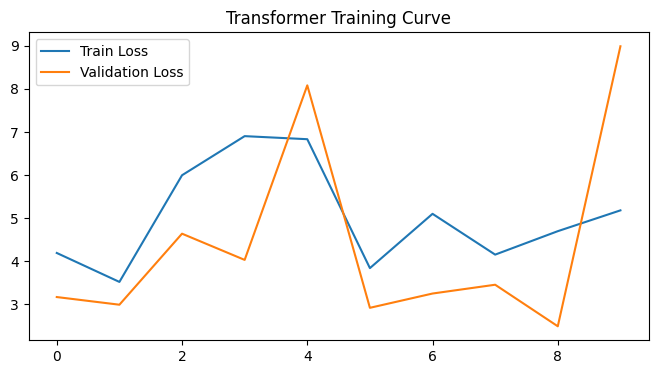

In [23]:
# Training Stability Curve
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.title("Transformer Training Curve")
plt.show()


In [24]:
# Save Model and Training History
transformer_model.save("models/transformer_model.keras")

with open("models/transformer_history.json", "w") as f:
    json.dump(history.history, f)
